In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import skimage
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

np.random.seed(42)

In [9]:
dataset_path = './asl_dataset'
class_names = [
  '0','1','2','3','4','5','6',
  '7','8','9','a','b','c','d',
  'e','f','g','h','i','j','k',
  'l','m','n','o','p','q','r',
  's','t','u','v','w','x','y',
  'z'
]
# Loading and preprocessing Image Data https://www.section.io/engineering-education/image-preprocessing-in-python/#:~:text=In%20this%20tutorial%2C%20we%20shall,used%20to%20preprocess%20image%20data.
dataPaths = []
for i in range(len(class_names)):
  path = os.path.join(dataset_path, class_names[i], '*')
  path = glob.glob(path)
  dataPaths.append(path)


# Merging Dataframes: https://www.stackvidhya.com/add-row-to-dataframe/
df = pd.DataFrame()
for i in range(len(dataPaths)):
  current_df = pd.DataFrame({"path": dataPaths[i], "category": class_names[i]})
  df = pd.concat([df, current_df], ignore_index=True, axis=0)
df.to_csv(f'./temp/categorized.csv')


40 40


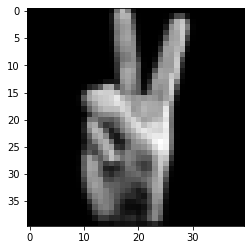

In [85]:
# gray_image = skimage.color.rgb2gray(io.imread(df['path'][200]))
# Starting with downscaled image
gray_image = rescale(skimage.color.rgb2gray(io.imread(df['path'][200])), 0.1)
plt.imshow(gray_image, cmap = 'gray')
pixels = gray_image.shape[0] * gray_image.shape[1]


In [27]:
column_names = []
[column_names.append("p"+str(x)) for x in range(0,pixels)] # shape (785,0)
column_names.append("category")
numberized_df = pd.DataFrame(columns=column_names)
for i in range(len(class_names)):
  print(class_names[i])
  for j in range(len(dataPaths[i])):
    image = io.imread(dataPaths[i][j])
    gray_image = rescale(skimage.color.rgb2gray(image), 0.1)
    numberized_image = gray_image.flatten()
    numberized_image = np.append(numberized_image, i)
    numberized_image_df = pd.DataFrame(columns=column_names)
    numberized_image_df.loc[0] = numberized_image
    numberized_df = pd.concat([numberized_df,numberized_image_df], ignore_index=True)

0
1
2
3
4
5
6
7
8
9
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


In [69]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(numberized_df, numberized_df['category']):
    train_set = numberized_df.loc[train_index]
    test_set = numberized_df.loc[test_index]

train_data = train_set.drop("category", axis=1) 
train_labels = train_set["category"].copy().to_numpy().astype('int')
print(train_labels)

test_data = test_set.drop("category", axis=1) 
test_labels = test_set["category"].copy().to_numpy().astype('int')
print(test_data.shape)

[14 24 20 ... 30 22 35]
(755, 1600)


In [64]:
# I THINK IT IS ALSREADY SCALED BETWEEN ! AND ) BUT JUST TO BE SAFE !!

# REVISIT LATER

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data.values)

scaled_df = pd.DataFrame(train_scaled, index=train_set.index, columns=train_data.columns)

print(np.max(scaled_df.p1.to_numpy()))
print(np.min(scaled_df.p1.to_numpy()))

1.0
0.0


In [102]:
model = SVC(random_state=42, probability=True)

# specify the parameter combinations to be tested
parameters = [
    {'C': [10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['linear', 'rbf']}
]
grid_search = GridSearchCV(model, parameters)#, cv=10, return_train_score=True, n_jobs=-1)
grid_search.fit(train_scaled, train_labels)



GridSearchCV(estimator=SVC(probability=True, random_state=42),
             param_grid=[{'C': [10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'rbf']}])

In [67]:
train_predictions = grid_search.best_estimator_.predict(train_scaled)
cls_report_train = classification_report(train_labels, train_predictions)
print(cls_report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        49
           5       1.00      1.00      1.00        49
           6       1.00      1.00      1.00        49
           7       1.00      1.00      1.00        49
           8       1.00      1.00      1.00        49
           9       1.00      1.00      1.00        49
          10       1.00      1.00      1.00        49
          11       1.00      1.00      1.00        49
          12       1.00      1.00      1.00        49
          13       1.00      1.00      1.00        49
          14       1.00      1.00      1.00        49
          15       1.00      1.00      1.00        49
          16       1.00      1.00      1.00        49
          17       1.00    

In [70]:
test_scaled = scaler.transform(test_data.values)
test_predictions = grid_search.best_estimator_.predict(test_scaled)
cls_report_test = classification_report(test_labels, test_predictions)
print(cls_report_test)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.95      0.98        21
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        21
           4       1.00      0.95      0.98        21
           5       1.00      1.00      1.00        21
           6       0.89      0.81      0.85        21
           7       0.95      0.95      0.95        21
           8       0.91      1.00      0.95        21
           9       1.00      0.95      0.98        21
          10       1.00      0.95      0.98        21
          11       1.00      1.00      1.00        21
          12       1.00      0.95      0.98        21
          13       1.00      1.00      1.00        21
          14       1.00      1.00      1.00        21
          15       1.00      1.00      1.00        21
          16       1.00      1.00      1.00        21
          17       1.00    

In [ ]:
# Pipeline




# User Testing
After training the model, I decided to use an actual picture of my own to see if I can get the right output

1600
0 : 0.0034849994363312757
1 : 0.0002041122251174405
2 : 0.000285008745508253
3 : 0.0006192157646110005
4 : 0.0006529516562337898
5 : 0.0015108819762719463
6 : 0.0004376993290755167
7 : 0.0007176794339487284
8 : 0.0005456284749094798
9 : 0.0004239694055383748
a : 0.020603715236888014
b : 0.000305956823470853
c : 0.002424928044374691
d : 0.00025264848890633855


/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature nam

e : 0.011971715142615375
f : 0.00026308225607964456
g : 0.008973831232694423
h : 0.0010459774116989371
i : 0.002324312990280723
j : 0.8003726252373343
k : 0.00026102303917388477
l : 0.0005185647663714566
m : 0.08855003229780975
n : 0.010366247471981137
o : 0.002934253946076952
p : 0.0006501662859940093
q : 0.006810870328561077
r : 0.00016698512371415847
s : 0.00949178285461032
t : 0.004079314767536878
u : 0.00018912429314063873
v : 0.00024219708686111098
w : 0.00032974085860028844
x : 0.0007984432986249062
y : 0.016944297665292343
z : 0.0002460166037605586


/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/home/logan/miniconda3/envs/csi4106/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature nam

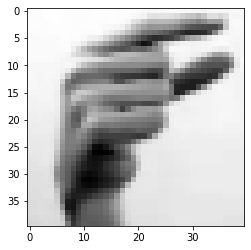

In [113]:

gray_image = resize(skimage.color.rgb2gray(io.imread('./MYTESTINGIMAGE/Selection_032.png')), (40, 40))
numberized_image = gray_image.flatten()
print(len(numberized_image))
column_names = []
[column_names.append("p"+str(x)) for x in range(0,len(numberized_image))] # shape (785,0)
numberized_df = pd.DataFrame(columns=column_names)

numberized_df = pd.DataFrame(columns=column_names)
numberized_image_df = pd.DataFrame(columns=column_names)
numberized_image_df.loc[0] = numberized_image

plt.imshow(gray_image, cmap = 'gray')

for i in range(len(class_names)):
  print(class_names[i], ':', grid_search.predict_proba(numberized_image_df)[0][i])